In [1]:
from textblob import TextBlob
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers


from warnings import filterwarnings
filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
import pandas as pd 
data = pd.read_csv('datasets/Womens Clothing E-Commerce Reviews.csv')

In [3]:
data

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [4]:
data["Rating"].replace(1, value = "negatif", inplace = True)
data["Rating"].replace(2, value = "negatif", inplace = True)
data["Rating"].replace(4, value = "pozitif", inplace = True)
data["Rating"].replace(5, value = "pozitif", inplace = True)
data = data[(data['Rating'] == "negatif") | (data['Rating'] == "pozitif")] 

In [5]:
df = pd.DataFrame()
df["comment"] = data["Review Text"]
df["sentiment"] = data["Rating"]

In [6]:
#buyuk-kucuk donusumu
df['comment'] = df['comment'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

In [7]:
#noktalama işaretleri
df['comment'] = df['comment'].str.replace('[^\w\s]','')

In [8]:
#sayılar
df['comment'] = df['comment'].str.replace('\d','')

In [9]:
#stopwords
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
df['comment'] = df['comment'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

In [10]:
#seyreklerin silinmesi
sil = pd.Series(' '.join(df['comment']).split()).value_counts()[-5000:]
df['comment'] = df['comment'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

In [11]:
#lemmi
from textblob import Word
#nltk.download('wordnet')
df['comment'] = df['comment'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 


In [12]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(df["comment"],
                                                                   df["sentiment"], 
                                                                    random_state = 1)
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

# özellik çıkarımı yöntemleri 

In [13]:
# count vektor
vectorizer = CountVectorizer() #ilk başta oluşturduğumuz train_x'i bozmamak için yeni vectorizer oluşturduk.
vectorizer.fit(train_x)
x_train_count = vectorizer.transform(train_x)
x_test_count = vectorizer.transform(test_x)

In [14]:
# tf-idf 
tf_idf_word_vectorizer = TfidfVectorizer() #ilk başta oluşturduğumuz train_x'i bozmamak için yeni vectorizer oluşturduk.
tf_idf_word_vectorizer.fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

In [15]:
# ngram level tf-idf
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range = (2,3))
tf_idf_ngram_vectorizer.fit(train_x)
x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(train_x)
x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(test_x)

In [16]:
# character level tf-idf
tf_idf_chars_vectorizer = TfidfVectorizer(analyzer = "char", ngram_range = (2,3))
tf_idf_chars_vectorizer.fit(train_x)
x_train_tf_idf_chars = tf_idf_chars_vectorizer.transform(train_x)
x_test_tf_idf_chars = tf_idf_chars_vectorizer.transform(test_x)

# makine öğrenmesi sınıflandırma algoritmaları

# logistic reggression

In [24]:
loj = linear_model.LogisticRegression()
loj_model = loj.fit(x_train_count, train_y)

accuracy = model_selection.cross_val_score(loj_model, x_test_count, test_y, cv = 10).mean()
recall = model_selection.cross_val_score(loj_model, x_test_count, test_y, cv=10, scoring='recall').mean()
precision = model_selection.cross_val_score(loj_model, x_test_count, test_y, cv=10, scoring='precision').mean()
f1_score =  model_selection.cross_val_score(loj_model, x_test_count, test_y, cv=10, scoring='f1_macro').mean()

print("Count Vectors Doğruluk Oranı:", accuracy)
print("Count Vectors Recall:", recall)
print("Count Vectors Precision:", precision)
print("Count Vectors F1 Score:", f1_score)

Count Vectors Doğruluk Oranı: 0.9194818243395799
Count Vectors Recall: 0.9705721033352612
Count Vectors Precision: 0.9403328903472963
Count Vectors F1 Score: 0.7791970089600667


In [25]:
loj1 = linear_model.LogisticRegression()
loj_model1 = loj1.fit(x_train_tf_idf_word,train_y)

accuracy1 = model_selection.cross_val_score(loj_model1, x_test_tf_idf_word, test_y, cv = 10).mean()
recall1 = model_selection.cross_val_score(loj_model1, x_test_tf_idf_word, test_y, cv=10, scoring='recall').mean()
precision1 = model_selection.cross_val_score(loj_model1, x_test_tf_idf_word, test_y, cv=10, scoring='precision').mean()
f1_score1 =  model_selection.cross_val_score(loj_model1, x_test_tf_idf_word, test_y, cv=10, scoring='f1_macro').mean()

print("Word-Level TF-IDF Doğruluk Oranı:", accuracy1)
print("Word-Level TF-IDF Recall:", recall1)
print("Word-Level TF-IDF Precision:", precision1)
print("Word-Level TF-IDF F1 Score:", f1_score1)

Word-Level TF-IDF Doğruluk Oranı: 0.9031835628810116
Word-Level TF-IDF Recall: 0.9964854443801812
Word-Level TF-IDF Precision: 0.9038354494642595
Word-Level TF-IDF F1 Score: 0.632344737609466


In [27]:
loj2 = linear_model.LogisticRegression()
loj_model2 = loj2.fit(x_train_tf_idf_ngram,train_y)

accuracy2 = model_selection.cross_val_score(loj_model2, x_test_tf_idf_ngram, test_y, cv = 10).mean()
recall2 = model_selection.cross_val_score(loj_model2, x_test_tf_idf_ngram, test_y, cv=10, scoring='recall').mean()
precision2 = model_selection.cross_val_score(loj_model2, x_test_tf_idf_ngram, test_y, cv=10, scoring='precision').mean()
f1_score2 =  model_selection.cross_val_score(loj_model2, x_test_tf_idf_ngram, test_y, cv=10, scoring='f1_macro').mean()

print("N-GRAM TF-IDF Doğruluk Oranı:", accuracy2)
print("N-GRAM TF-IDF Recall:", recall2)
print("N-GRAM TF-IDF Precision:", precision2)
print("N-GRAM TF-IDF F1 Score:", f1_score2)

N-GRAM TF-IDF Doğruluk Oranı: 0.883585459471664
N-GRAM TF-IDF Recall: 1.0
N-GRAM TF-IDF Precision: 0.883585459471664
N-GRAM TF-IDF F1 Score: 0.4690976199567265


In [28]:
loj3 = linear_model.LogisticRegression()
loj_model3 = loj3.fit(x_train_tf_idf_chars,train_y)

accuracy3 = model_selection.cross_val_score(loj_model3, x_test_tf_idf_chars, test_y, cv = 10).mean()
recall3 = model_selection.cross_val_score(loj_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='recall').mean()
precision3 = model_selection.cross_val_score(loj_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='precision').mean()
f1_score3 =  model_selection.cross_val_score(loj_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='f1_macro').mean()

print("CHARLEVEL TF-IDF Doğruluk Oranı:", accuracy3)
print("CHARLEVEL TF-IDF Recall:", recall3)
print("CHARLEVEL TF-IDF Precision:", precision3)
print("CHARLEVEL TF-IDF F1 Score:", f1_score3)

CHARLEVEL TF-IDF Doğruluk Oranı: 0.9010483931662527
CHARLEVEL TF-IDF Recall: 0.9927530364372469
CHARLEVEL TF-IDF Precision: 0.9046169089679361
CHARLEVEL TF-IDF F1 Score: 0.6338105380649196


# naive bayes

In [29]:
nb = naive_bayes.MultinomialNB()
nb_model = nb.fit(x_train_count,train_y)

accuracy4 = model_selection.cross_val_score(nb_model, x_test_count, test_y, cv = 10).mean()
recall4 = model_selection.cross_val_score(nb_model, x_test_count, test_y, cv=10, scoring='recall').mean()
precision4 = model_selection.cross_val_score(nb_model, x_test_count, test_y, cv=10, scoring='precision').mean()
f1_score4 =  model_selection.cross_val_score(nb_model, x_test_count, test_y, cv=10, scoring='f1_macro').mean()

print("Count Vectors Doğruluk Oranı:", accuracy4)
print("Count Vectors Recall:", recall4)
print("Count Vectors Precision:", precision4)
print("Count Vectors F1 Score:", f1_score4)

Count Vectors Doğruluk Oranı: 0.9093877474222924
Count Vectors Recall: 0.9960458839406208
Count Vectors Precision: 0.9099489907422351
Count Vectors F1 Score: 0.6711089229024081


In [30]:
nb1 = naive_bayes.MultinomialNB()
nb_model1 = nb1.fit(x_train_tf_idf_word,train_y)

accuracy5 = model_selection.cross_val_score(nb_model1, x_test_tf_idf_word, test_y, cv = 10).mean()
recall5 = model_selection.cross_val_score(nb_model1, x_test_tf_idf_word, test_y, cv=10, scoring='recall').mean()
precision5 = model_selection.cross_val_score(nb_model1, x_test_tf_idf_word, test_y, cv=10, scoring='precision').mean()
f1_score5 =  model_selection.cross_val_score(nb_model1, x_test_tf_idf_word, test_y, cv=10, scoring='f1_macro').mean()

print("Word-Level TF-IDF Doğruluk Oranı:", accuracy5)
print("Word-Level TF-IDF Recall:", recall5)
print("Word-Level TF-IDF Precision:", precision5)
print("Word-Level TF-IDF F1 Score:", f1_score5)

Word-Level TF-IDF Doğruluk Oranı: 0.883585459471664
Word-Level TF-IDF Recall: 1.0
Word-Level TF-IDF Precision: 0.883585459471664
Word-Level TF-IDF F1 Score: 0.4690976199567265


In [31]:
nb2 = naive_bayes.MultinomialNB()
nb_model2 = nb2.fit(x_train_tf_idf_ngram,train_y)

accuracy6 = model_selection.cross_val_score(nb_model2, x_test_tf_idf_ngram, test_y, cv = 10).mean()
recall6 = model_selection.cross_val_score(nb_model2, x_test_tf_idf_ngram, test_y, cv=10, scoring='recall').mean()
precision6 = model_selection.cross_val_score(nb_model2, x_test_tf_idf_ngram, test_y, cv=10, scoring='precision').mean()
f1_score6 =  model_selection.cross_val_score(nb_model2, x_test_tf_idf_ngram, test_y, cv=10, scoring='f1_macro').mean()

print("N-GRAM TF-IDF Doğruluk Oranı:", accuracy6)
print("N-GRAM TF-IDF Recall:", recall6)
print("N-GRAM TF-IDF Precision:", precision6)
print("N-GRAM TF-IDF F1 Score:", f1_score6)

N-GRAM TF-IDF Doğruluk Oranı: 0.883585459471664
N-GRAM TF-IDF Recall: 1.0
N-GRAM TF-IDF Precision: 0.883585459471664
N-GRAM TF-IDF F1 Score: 0.4690976199567265


In [32]:
nb3 = naive_bayes.MultinomialNB()
nb_model3 = nb3.fit(x_train_tf_idf_chars,train_y)

accuracy7 = model_selection.cross_val_score(nb_model3, x_test_tf_idf_chars, test_y, cv = 10).mean()
recall7 = model_selection.cross_val_score(nb_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='recall').mean()
precision7 = model_selection.cross_val_score(nb_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='precision').mean()
f1_score7 =  model_selection.cross_val_score(nb_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='f1_macro').mean()

print("CHARLEVEL TF-IDF Doğruluk Oranı:", accuracy7)
print("CHARLEVEL TF-IDF Recall:", recall7)
print("CHARLEVEL TF-IDF Precision:", precision7)
print("CHARLEVEL TF-IDF F1 Score:", f1_score7)

CHARLEVEL TF-IDF Doğruluk Oranı: 0.883585459471664
CHARLEVEL TF-IDF Recall: 1.0
CHARLEVEL TF-IDF Precision: 0.883585459471664
CHARLEVEL TF-IDF F1 Score: 0.4690976199567265


# random forest

In [33]:
rf = ensemble.RandomForestClassifier()
rf_model = rf.fit(x_train_count,train_y)

accuracy8 = model_selection.cross_val_score(rf_model, x_test_count, test_y, cv = 10).mean()
recall8 = model_selection.cross_val_score(rf_model, x_test_count, test_y, cv=10, scoring='recall').mean()
precision8 = model_selection.cross_val_score(rf_model, x_test_count, test_y, cv=10, scoring='precision').mean()
f1_score8 =  model_selection.cross_val_score(rf_model, x_test_count, test_y, cv=10, scoring='f1_macro').mean()

print("Count Vectors Doğruluk Oranı:", accuracy8)
print("Count Vectors Recall:", recall8)
print("Count Vectors Precision:", precision8)
print("Count Vectors F1 Score:", f1_score8)

Count Vectors Doğruluk Oranı: 0.8925103484609018
Count Vectors Recall: 0.9993411413148255
Count Vectors Precision: 0.8915333660987796
Count Vectors F1 Score: 0.5314486558425064


In [34]:
rf1 = ensemble.RandomForestClassifier()
rf_model1 = rf1.fit(x_train_tf_idf_word,train_y)

accuracy9 = model_selection.cross_val_score(rf_model1, x_test_tf_idf_word, test_y, cv = 10).mean()
recall9 = model_selection.cross_val_score(rf_model1, x_test_tf_idf_word, test_y, cv=10, scoring='recall').mean()
precision9 = model_selection.cross_val_score(rf_model1, x_test_tf_idf_word, test_y, cv=10, scoring='precision').mean()
f1_score9 =  model_selection.cross_val_score(rf_model1, x_test_tf_idf_word, test_y, cv=10, scoring='f1_macro').mean()

print("Word-Level TF-IDF Doğruluk Oranı:", accuracy9)
print("Word-Level TF-IDF Recall:", recall9)
print("Word-Level TF-IDF Precision:", precision9)
print("Word-Level TF-IDF F1 Score:", f1_score9)

Word-Level TF-IDF Doğruluk Oranı: 0.8901832618348763
Word-Level TF-IDF Recall: 0.998901580875265
Word-Level TF-IDF Precision: 0.8902737121782627
Word-Level TF-IDF F1 Score: 0.5324054640129162


In [37]:
rf2 = ensemble.RandomForestClassifier()
rf_model2 = rf2.fit(x_train_tf_idf_ngram,train_y)

accuracy10 = model_selection.cross_val_score(rf_model2, x_test_tf_idf_ngram, test_y, cv = 10).mean()
recall10 = model_selection.cross_val_score(rf_model2, x_test_tf_idf_ngram, test_y, cv=10, scoring='recall').mean()
precision10 = model_selection.cross_val_score(rf_model2, x_test_tf_idf_ngram, test_y, cv=10, scoring='precision').mean()
f1_score10 =  model_selection.cross_val_score(rf_model2, x_test_tf_idf_ngram, test_y, cv=10, scoring='f1_macro').mean()

print("N-GRAM TF-IDF Doğruluk Oranı:", accuracy10)
print("N-GRAM TF-IDF Recall:", recall10)
print("N-GRAM TF-IDF Precision:", precision10)
print("N-GRAM TF-IDF F1 Score:", f1_score10)

KeyboardInterrupt: 

In [36]:
rf3 = ensemble.RandomForestClassifier()
rf_model3 = rf3.fit(x_train_tf_idf_chars,train_y)

accuracy11 = model_selection.cross_val_score(rf_model3, x_test_tf_idf_chars, test_y, cv = 10).mean()
recall11 = model_selection.cross_val_score(rf_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='recall').mean()
precision11 = model_selection.cross_val_score(rf_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='precision').mean()
f1_score11 =  model_selection.cross_val_score(rf_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='f1_macro').mean()

print("CHARLEVEL TF-IDF Doğruluk Oranı:", accuracy11)
print("CHARLEVEL TF-IDF Recall:", recall11)
print("CHARLEVEL TF-IDF Precision:", precision11)
print("CHARLEVEL TF-IDF F1 Score:", f1_score11)

CHARLEVEL TF-IDF Doğruluk Oranı: 0.8870790998720555
CHARLEVEL TF-IDF Recall: 0.9993411413148255
CHARLEVEL TF-IDF Precision: 0.888522124237223
CHARLEVEL TF-IDF F1 Score: 0.5218680669412484


# graph

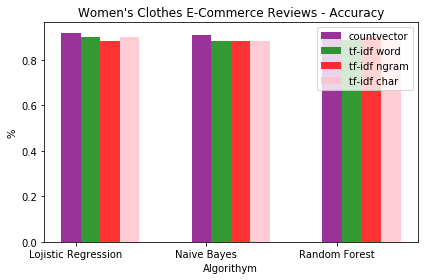

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 3
cv = (accuracy, accuracy4, accuracy8)
word = (accuracy1, accuracy5, accuracy9)
ngram = (accuracy2, accuracy6, 0.90)
char = (accuracy3, accuracy7, accuracy11)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

rects1 = plt.bar(index, cv, bar_width,
alpha=opacity,
color='purple',
label='countvector')

rects2 = plt.bar(index + bar_width, word, bar_width,
alpha=opacity,
color='g',
label='tf-idf word')

rects3 = plt.bar(index + bar_width*2, ngram, bar_width,
alpha=opacity,
color='red',
label='tf-idf ngram')

rects3 = plt.bar(index + bar_width*3, char, bar_width,
alpha=opacity,
color='pink',
label='tf-idf char')

plt.xlabel('Algorithym')
plt.ylabel('%')
plt.title("Women's Clothes E-Commerce Reviews - Accuracy")
plt.xticks(index + bar_width/4, ('Lojistic Regression', 'Naive Bayes', 'Random Forest'))
plt.legend()

plt.tight_layout()
plt.show()

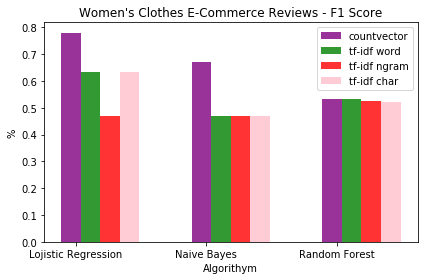

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 3
cv = (f1_score, f1_score4, f1_score8)
word = (f1_score1, f1_score5, f1_score9)
ngram = (f1_score2, f1_score6, 0.5260)
char = (f1_score3, f1_score7, f1_score11)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

rects1 = plt.bar(index, cv, bar_width,
alpha=opacity,
color='purple',
label='countvector')

rects2 = plt.bar(index + bar_width, word, bar_width,
alpha=opacity,
color='g',
label='tf-idf word')

rects3 = plt.bar(index + bar_width*2, ngram, bar_width,
alpha=opacity,
color='red',
label='tf-idf ngram')

rects3 = plt.bar(index + bar_width*3, char, bar_width,
alpha=opacity,
color='pink',
label='tf-idf char')

plt.xlabel('Algorithym')
plt.ylabel('%')
plt.title("Women's Clothes E-Commerce Reviews - F1 Score")
plt.xticks(index + bar_width/4, ('Lojistic Regression', 'Naive Bayes', 'Random Forest'))
plt.legend()

plt.tight_layout()
plt.show()